In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy, math

data = pd.read_csv('../../notes and data/KDDCup99.csv')
data['label'] = data['label'].apply(lambda x: 1 if x != 'normal' else 0)


In [124]:
X = data.drop(columns=['label'])  # All columns except 'label'
y = data['label'].values  
X = pd.get_dummies(x, drop_first=True).astype(int)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)
dfarr = np.array(df_scaled)
epsilon = 1e-10

In [125]:
def probability(x, mean, stddev):
    prob = np.zeros(x.shape)
    mean = mean.reshape(1, -1)
    stddev = stddev.reshape(1, -1)
    stddev = np.clip(stddev, epsilon, None)
    exponent = np.exp(-0.5 * ((x - mean) ** 2) / (stddev ** 2))
    prob = (1 / (np.sqrt(2 * np.pi) * stddev)) * exponent
    return prob

In [126]:
# Anomaly detection based on product of probabilities
def anomaly(x, mean, stddev):
    prob = probability(x, mean, stddev)
    # Use log to prevent overflow and underflow issues
    log_prob = np.log(prob + epsilon)  # Adding epsilon to avoid log(0)
    anomaly_score = np.sum(log_prob)  # Summing the log probabilities
    return anomaly_score

# Anomaly detection based on sum of log(probabilities)
def anomalylog(x, mean, stddev):
    prob = probability(x, mean, stddev)
    # Adding epsilon to avoid log(0) issues
    log_prob = np.log(prob + epsilon)  # Adding epsilon to avoid log(0)
    anomaly_score = np.sum(log_prob)  # Summing the log probabilities
    return anomaly_score

In [127]:
# Split into 80% training and 20% testing
# x_small, _, y_small, _ = train_test_split(dfarr, y, train_size=2000, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfarr, y, test_size=0.2, random_state=42)

In [131]:
def predictAnomaly(xx):
    mean_train = np.mean(dfarr, axis=0)
    stddev_train = np.std(dfarr, axis=0)
    anomaly_scores_test = []
    logAnomaly_scores = []
    for i in range(len(xx)):
        if i % math.ceil(len(xx) / 10) == 0:
            print(f"Iteration {i:4d}")
        logscore = anomalylog(xx[i], mean_train, stddev_train)
        score = anomaly(xx[i], mean_train, stddev_train)
        anomaly_scores_test.append(score)
        logAnomaly_scores.append(logscore)
    return anomaly_scores_test,logAnomaly_scores
anomaly_scores_test,logAnomaly_scores =predictAnomaly(dfarr)

Iteration    0
Iteration 49402
Iteration 98804
Iteration 148206
Iteration 197608
Iteration 247010
Iteration 296412
Iteration 345814
Iteration 395216
Iteration 444618


In [132]:
print(dfarr.shape)
print(y.shape)
print(len(logAnomaly_scores))
print(anomaly_scores_test[:10])
print(logAnomaly_scores[:10])

(494020, 115)
(494020,)
494020
[-78.64541799334823, -77.95935599851234, -77.31562355881405, -76.72835075051694, -76.15060233003535, -75.60508343174632, -100.09995114172044, -77.66949354529936, -77.69580352037613, -78.37236456815097]
[-78.64541799334823, -77.95935599851234, -77.31562355881405, -76.72835075051694, -76.15060233003535, -75.60508343174632, -100.09995114172044, -77.66949354529936, -77.69580352037613, -78.37236456815097]


In [184]:
# threshold = np.mean(anomaly_scores_test) - np.std(anomaly_scores_test)
threshold = -115.75490954497944
print(np.mean(anomaly_scores_test))
anomalies = [1 if score > threshold else 0 for score in anomaly_scores_test]
datas = pd.DataFrame({
    'Anomaly_Score': anomaly_scores_test,
    'True_Label': y,
    'anomaly value': anomalies
})

dataa = datas[(datas['True_Label'] == 0) & (datas['anomaly value'] == 1)].copy()  # Filter rows where True_Label is 0 and copy to a new DataFrame
print(threshold,dataa)


-74.3062607223359
-115.75490954497944         Anomaly_Score  True_Label  anomaly value
0          -78.645418           0              1
1          -77.959356           0              1
2          -77.315624           0              1
3          -76.728351           0              1
4          -76.150602           0              1
...               ...         ...            ...
494015     -74.041730           0              1
494016     -77.581771           0              1
494017     -76.997007           0              1
494018     -76.520007           0              1
494019     -77.450713           0              1

[88713 rows x 3 columns]


In [185]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y, anomalies))
print("Recall: ", recall_score(y, anomalies))
print("F1-Score: ", f1_score(y, anomalies))


Precision:  0.8155359589788802
Recall:  0.9885744676024529
F1-Score:  0.8937568505559063


In [178]:
Precision:  0.8532576049737639
Recall:  0.9201472993852443
F1-Score:  0.8854409717337628
threshold: -85

SyntaxError: illegal target for annotation (1865580444.py, line 3)

In [179]:
anomalies = np.array(anomalies)
TP = np.sum((y == 1) & (anomalies == 1))
TN = np.sum((y == 0) & (anomalies == 0))
FP = np.sum((y == 0) & (anomalies == 1))
FN = np.sum((y == 1) & (anomalies == 0))
print(np.sum((y == 1)))

396743


[0.80309097 0.8532576  1.        ]
[1.        0.9201473 0.       ]


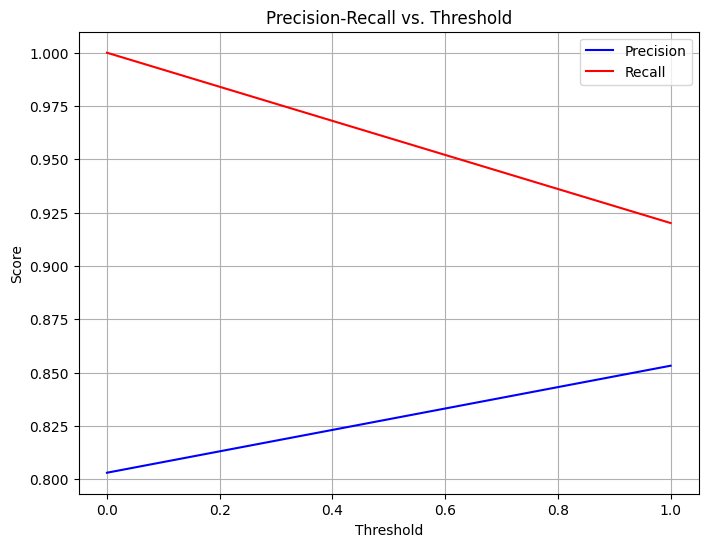

In [180]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming 'anomaly_scores' contains the continuous anomaly scores for x_test
# and 'y_test' contains the true labels (0 for normal, 1 for anomaly)

# Calculate precision, recall, and thresholds
precisions, recalll, thresholds = precision_recall_curve(y, anomalies)
print(precisions)
print(recalll)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()


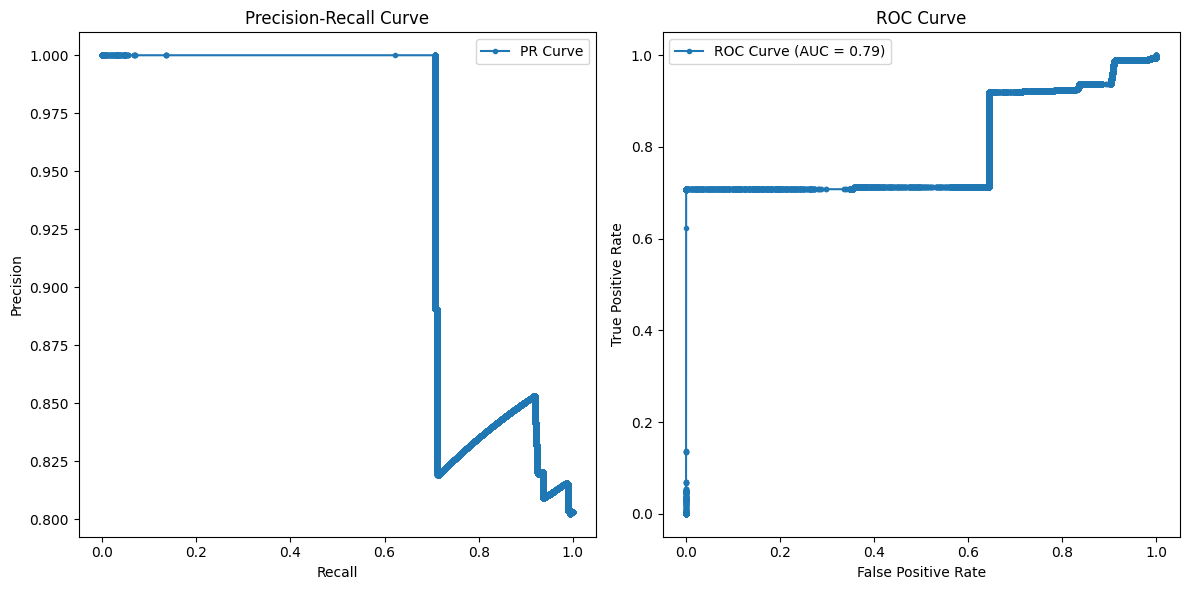

In [182]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Assuming `anomaly_scores_test` contains anomaly scores for the test set
# and `y_test` contains the true labels (1 = anomaly, 0 = normal)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y, anomaly_scores_test)

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y, anomaly_scores_test)

# Plot Precision-Recall Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.', label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f"ROC Curve (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [183]:
from sklearn.metrics import f1_score

# Calculate F1 score at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold with the highest F1 score
optimal_threshold_pr = pr_thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold (Precision-Recall): {optimal_threshold_pr}")


Optimal Threshold (Precision-Recall): -115.75490954497944
